# Transformers, can you rate the complexity of reading passages?
## Fine-tuning RoBERTa with PyTorch to predict reading ease of text excerpts

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

import torch, transformers, os, gc, random
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import RobertaTokenizer, RobertaModel

import warnings
warnings.filterwarnings("ignore")

In [2]:
from transformers import __version__
print("Transformers version:", __version__)
print("PyTorch version:", torch.__version__)

Transformers version: 4.6.1
PyTorch version: 1.7.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')    

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
# https://pytorch.org/docs/stable/notes/randomness.html

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Random Seed

In [5]:
def set_random_seed(seed):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    

# Load Data

In [6]:
# You may need to change the path to where the file resides.

df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
print("Training dataset shape : " + str(df.shape))

Training dataset shape : (2834, 6)


In [7]:
# Preview of the dataset.

df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


From the graph below we can see that there's a record with 0 `target`, and 0 `standard error` (measure of spread of scores among multiple raters for each `excerpt`). The `excerpt` from this record is basically the baseline for all other comparisons.

We will remove this record from the dataset.

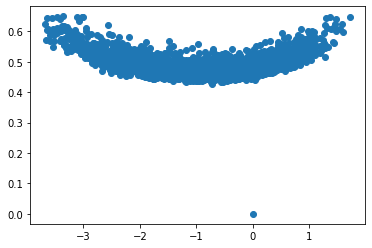

In [8]:
plt.scatter(x = df["target"], y = df["standard_error"])
plt.show()

In [9]:
# Remove record with 0 target and 0 standard_error.

df.drop(df[(df.target == 0) & (df.standard_error == 0)].index, inplace=True)
df.reset_index(drop=True, inplace=True)

print(" Training dataset shape : " + str(df.shape))

 Training dataset shape : (2833, 6)


In [10]:
# The target column values ranges from -3.676268 to 1.711390
# with mean of -0.959657.

df.describe()

,target,standard_error
count,2833.000000,2833.000000
mean,-0.959657,0.491609
std,1.033604,0.033577
min,-3.676268,0.428233
25%,-1.691501,0.468553
50%,-0.913322,0.484748
75%,-0.203079,0.506304
max,1.711390,0.649671


# Split Data into Training Set & Validation Set

In [11]:
set_random_seed(3377)
df["skfold"] = -99

df = df.sample(frac=1).reset_index(drop=True)
bins = int(np.floor(1 + np.log2(len(df))))
df.loc[:, "bins"] = pd.cut(df["target"], bins=bins, labels=False)
skf = StratifiedKFold(n_splits = 5)

for fold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df["bins"].values)):
    df.loc[val_idx, "skfold"] = fold

In [12]:
# Number of records under each fold.
df["skfold"].value_counts().sort_index()

0    567
1    567
2    567
3    566
4    566
Name: skfold, dtype: int64

In [13]:
# For each fold, the mean target is almost consistent.
# They are very close to the mean target -0.959657 for the entire dataset.

df.groupby("skfold")["target"].mean()

skfold
0   -0.957277
1   -0.964158
2   -0.960363
3   -0.968208
4   -0.948276
Name: target, dtype: float64

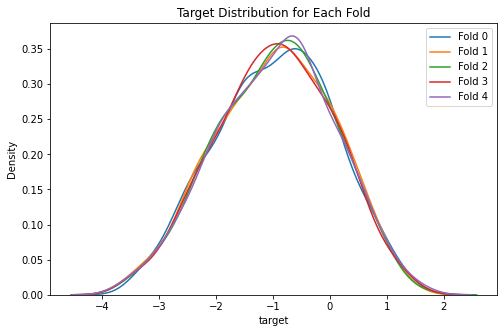

In [14]:
import seaborn as sns

plt.figure(figsize=(8,5))
for fold in range(max(df["skfold"])+1):
    sns.distplot(df[df["skfold"]==fold]["target"], 
                 hist=False,
                 kde = True,
                 label = f"Fold {fold}"
                )
    
plt.title(f"Target Distribution for Each Fold")
plt.legend(loc="best") 
plt.show()

# Dataset

In [15]:
class MyDataset(torch.utils.data.Dataset):
   
    def __init__(self, texts, targets, tokenizer, seq_len=250):        
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    
    def __len__(self):
        """Returns the length of dataset."""
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
        For a given item index, return a dictionary of encoded information        
        """        
        text = str(self.texts[idx]) 
        
        tokenized = self.tokenizer(
            text,            
            max_length = self.seq_len,                                
            padding = "max_length",     # Pad to the specified max_length. 
            truncation = True,          # Truncate to the specified max_length. 
            add_special_tokens = True,  # Whether to insert [CLS], [SEP], <s>, etc.   
            return_attention_mask = True            
        )     
        
        return {"ids": torch.tensor(tokenized["input_ids"], dtype=torch.long),
                "masks": torch.tensor(tokenized["attention_mask"], dtype=torch.long),
                "target": torch.tensor(self.targets[idx], dtype=torch.float)
               }

# Model

In [16]:
class MyModel(nn.Module):
            
    def __init__(self):        
        super().__init__() 
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')       
        self.regressor = nn.Linear(768, 1)     

    def forward(self, input_ids, attention_mask):        
        raw_output = self.roberta_model(input_ids, attention_mask, return_dict=True)        
        pooler = raw_output["pooler_output"]    # Shape is [batch_size, 768]
        output = self.regressor(pooler)         # Shape is [batch_size, 1]
        return output 

In [17]:
class AttentionHead(nn.Module):
    
    def __init__(self, input_dim=768, hidden_dim=512):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, last_hidden_state):
        """
        Note:
        "last_hidden_state" shape is [batch_size, seq_len, 768].
        The "weights" produced from softmax will add up to 1 across all tokens in each record.
        """        
        linear1_output = self.linear1(last_hidden_state)  # Shape is [batch_size, seq_len, 512]  
        activation = torch.tanh(linear1_output)           # Shape is [batch_size, seq_len, 512]        
        score = self.linear2(activation)                  # Shape is [batch_size, seq_len, 1]        
        weights = torch.softmax(score, dim=1)             # Shape is [batch_size, seq_len, 1]              
        result = torch.sum(weights * last_hidden_state, dim=1) # Shape is [batch_size, 768]          
        return result

In [18]:
class MyModel_AttnHead(nn.Module):
            
    def __init__(self):        
        super().__init__() 
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')
        self.attn_head = AttentionHead(768, 512)       
        self.regressor = nn.Linear(768, 1)     
    
    def forward(self, input_ids, attention_mask):       
        raw_output = self.roberta_model(input_ids, attention_mask, return_dict=True)        
        last_hidden_state = raw_output["last_hidden_state"] # Shape is [batch_size, seq_len, 768]
        attn = self.attn_head(last_hidden_state)            # Shape is [batch_size, 768]
        output = self.regressor(attn)                       # Shape is [batch_size, 1]       
        return output 

In [19]:
class MyModel_ConcatLast4Layers(nn.Module):
            
    def __init__(self):        
        super().__init__() 
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')
        self.regressor = nn.Linear(768*4, 1)     
    
    def forward(self, input_ids, attention_mask):       
        raw_output = self.roberta_model(input_ids, attention_mask, 
                                        return_dict=True, output_hidden_states=True)        
        hidden_states = raw_output["hidden_states"] 
        hidden_states = torch.stack(hidden_states) # Shape is [13, batch_size, seq_len, 768]
        concat = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1) 
                                             # Shape is [batch_size, seq_len, 768*4]
        first_token = concat[:, 0, :]        # Take only 1st token, result in shape [batch_size, 768*4]
        output = self.regressor(first_token) # Shape is [batch_size, 1]    
        return output 

# Train Util

In [20]:
def loss_fn(predictions, targets):       
    return torch.sqrt(nn.MSELoss()(predictions, targets))

In [21]:
def train_fn(data_loader, model, optimizer, device, scheduler):
        
    model.train()                               # Put the model in training mode.               
    
    lr_list = []
    train_losses = [] 
       
    for batch in data_loader:                   # Loop over all batches.
        
        ids = batch["ids"].to(device, dtype=torch.long)
        masks = batch["masks"].to(device, dtype=torch.long)
        targets = batch["target"].to(device, dtype=torch.float) 
        
        optimizer.zero_grad()                   # To zero out the gradients.
        
        outputs = model(ids, masks).squeeze(-1) # Predictions from 1 batch of data.
        
        loss = loss_fn(outputs, targets)        # Get the training loss.
        train_losses.append(loss.item())

        loss.backward()                         # To backpropagate the error (gradients are computed).
        optimizer.step()                        # To update parameters based on current gradients.
        lr_list.append(optimizer.param_groups[0]["lr"])
        scheduler.step()                        # To update learning rate.
        
    return train_losses, lr_list

In [22]:
def validate_fn(data_loader, model, device):
        
    model.eval()                                    # Put model in evaluation mode.
    
    val_losses = []
        
    with torch.no_grad():                           # Disable gradient calculation.
        
        for batch in data_loader:                   # Loop over all batches.   
            
            ids = batch["ids"].to(device, dtype=torch.long)
            masks = batch["masks"].to(device, dtype=torch.long)
            targets = batch["target"].to(device, dtype=torch.float)

            outputs = model(ids, masks).squeeze(-1) # Predictions from 1 batch of data.
            
            loss = loss_fn(outputs, targets)        # Get the validation loss.
            val_losses.append(loss.item())
            
    return val_losses 

In [23]:
def plot_lr_schedule(learning_rates):
    x = np.arange(len(learning_rates))
    plt.plot(x, learning_rates)
    plt.title(f'Linear schedule')
    plt.ylabel("Learning Rate")
    plt.xlabel("Training Steps")
    plt.show()

In [24]:
def plot_train_val_losses(train_losses, val_losses, fold):
    x = np.arange(len(train_losses))
    plt.plot(x, train_losses, label="training loss", marker='o')
    plt.plot(x, val_losses, label="validation loss", marker='o')
    plt.legend(loc="best")   # to show the labels.
    plt.title(f'Fold {fold}: roberta-base')    
    plt.ylabel("RMSE")
    plt.xlabel(f"Epoch")    
    plt.show()

# Run Training

In [25]:
def run_training(df, model_head="pooler"):  
    
    """
    model_head: Accepted option is "pooler", "attnhead", or "concatlayer"
    """    
    EPOCHS = 20
    FOLDS = [0, 1, 2, 3, 4]   # Set the list of folds you want to train
    EARLY_STOP_THRESHOLD = 3    
    TRAIN_BS = 16             # Training batch size     
    VAL_BS = 64               # Validation batch size  
    cv = []                   # A list to hold the cross validation scores
    
    #=========================================================================
    # Prepare data and model for training
    #=========================================================================
    
    for fold in FOLDS:
        
        set_random_seed(3377)
        
        # Initialize the tokenizer
        tokenizer =  RobertaTokenizer.from_pretrained("roberta-base")

        # Fetch training data
        df_train = df[df["skfold"] != fold].reset_index(drop=True)

        # Fetch validation data
        df_val = df[df["skfold"] == fold].reset_index(drop=True)

        # Initialize training dataset
        train_dataset = MyDataset(texts = df_train["excerpt"].values,
                                  targets = df_train["target"].values,
                                  tokenizer = tokenizer)

        # Initialize validation dataset
        val_dataset = MyDataset(texts = df_val["excerpt"].values,
                                targets = df_val["target"].values,
                                tokenizer = tokenizer)

        # Create training dataloader
        train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BS,
                                       shuffle = True, num_workers = 2)

        # Create validation dataloader
        val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                     shuffle = False, num_workers = 2)

        # Initialize the cuda device (or use CPU if you don't have GPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Load model and send it to the device.        
        if model_head == "pooler":
            model = MyModel().to(device)
        elif model_head == "attnhead":
            model = MyModel_AttnHead().to(device)
        elif model_head == "concatlayer":
            model = MyModel_ConcatLast4Layers().to(device)
        else:
            raise ValueError(f"Unknown model_head: {model_head}") 

        # Get the AdamW optimizer
        optimizer = transformers.AdamW(model.parameters(), lr=1e-6)

        # Calculate the number of training steps (this is used by scheduler).
        # training steps = [number of batches] x [number of epochs].
        train_steps = int(len(df_train) / TRAIN_BS * EPOCHS)    

        # Get the learning rate scheduler    
        scheduler = transformers.get_scheduler(
                        "linear",    # Create a schedule with a learning rate that decreases linearly 
                                     # from the initial learning rate set in the optimizer to 0.
                        optimizer = optimizer,
                        num_warmup_steps = 0,
                        num_training_steps = train_steps)

        #=========================================================================
        # Training Loop - Start training the epochs
        #=========================================================================

        print(f"===== FOLD: {fold} =====")    
        best_rmse = 999
        early_stopping_counter = 0       
        all_train_losses = []
        all_val_losses = []
        all_lr = []

        for epoch in range(EPOCHS):

            # Call the train function and get the training loss
            train_losses, lr_list = train_fn(train_data_loader, model, optimizer, device, scheduler)
            train_loss = np.mean(train_losses)   
            all_train_losses.append(train_loss)
            all_lr.extend(lr_list)

            # Perform validation and get the validation loss
            val_losses = validate_fn(val_data_loader, model, device)
            val_loss = np.mean(val_losses)
            all_val_losses.append(val_loss)    

            rmse = val_loss

            # If there's improvement on the validation loss, save the model checkpoint.
            # Else do early stopping if threshold is reached.
            if rmse < best_rmse:            
                torch.save(model.state_dict(), f"roberta_base_fold_{fold}.pt")
                print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}, checkpoint saved.")
                best_rmse = rmse
                early_stopping_counter = 0
            else:
                print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}")
                early_stopping_counter += 1
            if early_stopping_counter > EARLY_STOP_THRESHOLD:
                print(f"FOLD: {fold}, Epoch: {epoch}, RMSE = {round(rmse,4)}")
                print(f"Early stopping triggered! Best RMSE: {round(best_rmse,4)}\n")                
                break

        # Plot the losses and learning rate schedule.
        plot_train_val_losses(all_train_losses, all_val_losses, fold)
        plot_lr_schedule(all_lr)   
        
        # Keep the best_rmse as cross validation score for the fold.
        cv.append(best_rmse)
        
    # Print the cross validation scores and their average.
    cv_rounded = [ round(elem, 4) for elem in cv ] 
    print(f"CV: {cv_rounded}") 
    print(f"Average CV: {round(np.mean(cv), 4)}\n") 

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 0 =====
FOLD: 0, Epoch: 0, RMSE = 0.96, checkpoint saved.
FOLD: 0, Epoch: 1, RMSE = 0.7807, checkpoint saved.
FOLD: 0, Epoch: 2, RMSE = 0.6788, checkpoint saved.
FOLD: 0, Epoch: 3, RMSE = 0.6222, checkpoint saved.
FOLD: 0, Epoch: 4, RMSE = 0.6126, checkpoint saved.
FOLD: 0, Epoch: 5, RMSE = 0.6401
FOLD: 0, Epoch: 6, RMSE = 0.615
FOLD: 0, Epoch: 7, RMSE = 0.6285
FOLD: 0, Epoch: 8, RMSE = 0.6337
FOLD: 0, Epoch: 8, RMSE = 0.6337
Early stopping triggered! Best RMSE: 0.6126



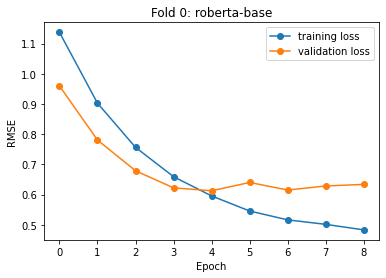

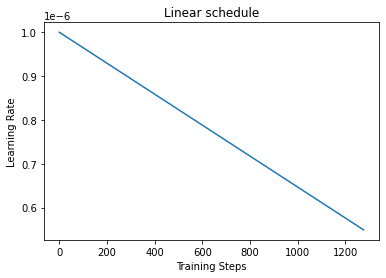

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 1 =====
FOLD: 1, Epoch: 0, RMSE = 0.9704, checkpoint saved.
FOLD: 1, Epoch: 1, RMSE = 0.7814, checkpoint saved.
FOLD: 1, Epoch: 2, RMSE = 0.6843, checkpoint saved.
FOLD: 1, Epoch: 3, RMSE = 0.6518, checkpoint saved.
FOLD: 1, Epoch: 4, RMSE = 0.6419, checkpoint saved.
FOLD: 1, Epoch: 5, RMSE = 0.6503
FOLD: 1, Epoch: 6, RMSE = 0.6703
FOLD: 1, Epoch: 7, RMSE = 0.6703
FOLD: 1, Epoch: 8, RMSE = 0.6493
FOLD: 1, Epoch: 8, RMSE = 0.6493
Early stopping triggered! Best RMSE: 0.6419



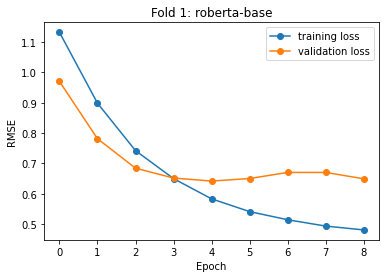

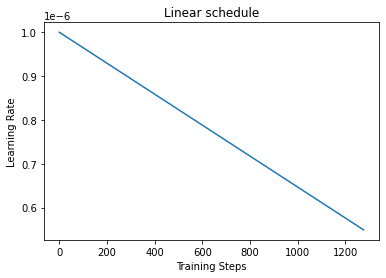

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 2 =====
FOLD: 2, Epoch: 0, RMSE = 0.9652, checkpoint saved.
FOLD: 2, Epoch: 1, RMSE = 0.7645, checkpoint saved.
FOLD: 2, Epoch: 2, RMSE = 0.6542, checkpoint saved.
FOLD: 2, Epoch: 3, RMSE = 0.6081, checkpoint saved.
FOLD: 2, Epoch: 4, RMSE = 0.5971, checkpoint saved.
FOLD: 2, Epoch: 5, RMSE = 0.5772, checkpoint saved.
FOLD: 2, Epoch: 6, RMSE = 0.5731, checkpoint saved.
FOLD: 2, Epoch: 7, RMSE = 0.6159
FOLD: 2, Epoch: 8, RMSE = 0.5633, checkpoint saved.
FOLD: 2, Epoch: 9, RMSE = 0.6533
FOLD: 2, Epoch: 10, RMSE = 0.6164
FOLD: 2, Epoch: 11, RMSE = 0.6398
FOLD: 2, Epoch: 12, RMSE = 0.6226
FOLD: 2, Epoch: 12, RMSE = 0.6226
Early stopping triggered! Best RMSE: 0.5633



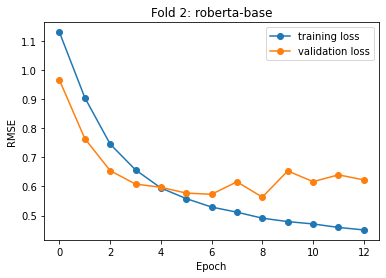

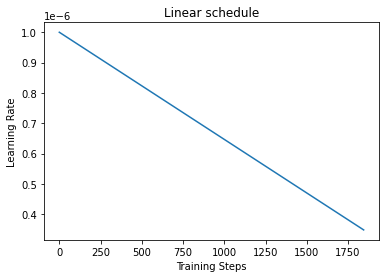

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 3 =====
FOLD: 3, Epoch: 0, RMSE = 0.9605, checkpoint saved.
FOLD: 3, Epoch: 1, RMSE = 0.7541, checkpoint saved.
FOLD: 3, Epoch: 2, RMSE = 0.6666, checkpoint saved.
FOLD: 3, Epoch: 3, RMSE = 0.6296, checkpoint saved.
FOLD: 3, Epoch: 4, RMSE = 0.6221, checkpoint saved.
FOLD: 3, Epoch: 5, RMSE = 0.6136, checkpoint saved.
FOLD: 3, Epoch: 6, RMSE = 0.6287
FOLD: 3, Epoch: 7, RMSE = 0.5637, checkpoint saved.
FOLD: 3, Epoch: 8, RMSE = 0.5998
FOLD: 3, Epoch: 9, RMSE = 0.615
FOLD: 3, Epoch: 10, RMSE = 0.6053
FOLD: 3, Epoch: 11, RMSE = 0.6304
FOLD: 3, Epoch: 11, RMSE = 0.6304
Early stopping triggered! Best RMSE: 0.5637



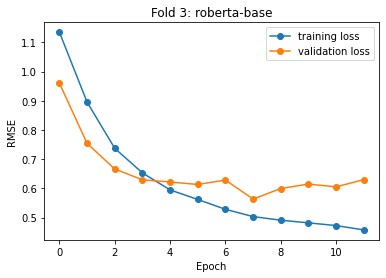

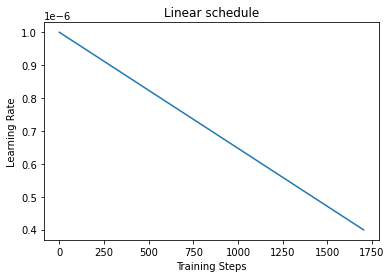

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===== FOLD: 4 =====
FOLD: 4, Epoch: 0, RMSE = 0.9726, checkpoint saved.
FOLD: 4, Epoch: 1, RMSE = 0.7585, checkpoint saved.
FOLD: 4, Epoch: 2, RMSE = 0.6583, checkpoint saved.
FOLD: 4, Epoch: 3, RMSE = 0.62, checkpoint saved.
FOLD: 4, Epoch: 4, RMSE = 0.6203
FOLD: 4, Epoch: 5, RMSE = 0.6198, checkpoint saved.
FOLD: 4, Epoch: 6, RMSE = 0.6211
FOLD: 4, Epoch: 7, RMSE = 0.5636, checkpoint saved.
FOLD: 4, Epoch: 8, RMSE = 0.5882
FOLD: 4, Epoch: 9, RMSE = 0.621
FOLD: 4, Epoch: 10, RMSE = 0.5978
FOLD: 4, Epoch: 11, RMSE = 0.6398
FOLD: 4, Epoch: 11, RMSE = 0.6398
Early stopping triggered! Best RMSE: 0.5636



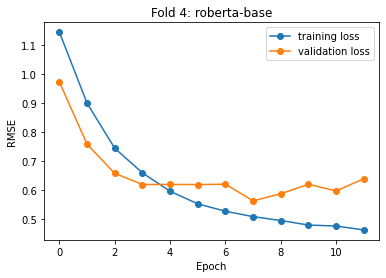

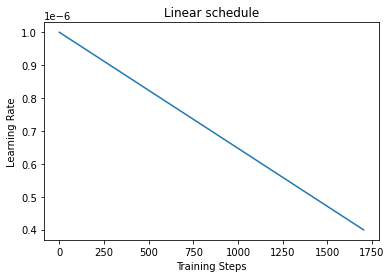

CV: [0.6126, 0.6419, 0.5633, 0.5637, 0.5636]
Average CV: 0.589

CPU times: user 56min 33s, sys: 41.7 s, total: 57min 15s
Wall time: 59min 39s


In [26]:
%%time
if __name__ == "__main__":
    run_training(df, model_head="pooler")    

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')    

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    7.1 GB
